In [11]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
#from pysankey import sankey
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import balanced_accuracy_score, roc_auc_score, accuracy_score, classification_report, confusion_matrix
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import GradientBoostingClassifier
from xgboost import XGBClassifier



In [18]:
# Helper functions
def count_by_group(data, feature, target):
    return data.groupby([feature, target])[target].count().reset_index().assign(
        pct=lambda x: x.groupby(feature)[target].transform('sum').rdiv(x[target]).mul(100)
    )

def classification_report_to_dataframe(true, predictions, predictions_proba, model_name, balanced='no'):
    report = classification_report(true, predictions, output_dict=True)
    report_df = pd.DataFrame.from_dict(report, orient='columns')
    report_df = report_df.rename(lambda x: x + '_' + report_df.index[0], axis='columns').iloc[0]
    report_df['Model'] = model_name
    report_df['Balanced'] = balanced
    report_df['Accuracy'] = accuracy_score(true, predictions)
    report_df['Balanced_Accuracy'] = balanced_accuracy_score(true, predictions)
    report_df['AUC'] = roc_auc_score(true, predictions_proba, average='macro')
    return report_df

def plot_confusion_matrix(cm, target_names, title='Confusion matrix', cmap=None, normalize=True):
    import matplotlib.pyplot as plt
    import numpy as np
    import itertools

    accuracy = np.trace(cm) / float(np.sum(cm))
    misclass = 1 - accuracy

    if cmap is None:
        cmap = plt.get_cmap('Blues')

    plt.figure(figsize=(8, 6))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()

    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names, rotation=45)
        plt.yticks(tick_marks, target_names)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 1.5 if normalize else cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if normalize:
            plt.text(j, i, "{:0.4f}".format(cm[i, j]), horizontalalignment="center", color="white" if cm[i, j] > thresh else "black")
        else:
            plt.text(j, i, "{:,}".format(cm[i, j]), horizontalalignment="center", color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label\naccuracy={:0.4f}; misclass={:0.4f}'.format(accuracy, misclass))
    plt.show()

def plot_feature_distributions(dataset, feature, target):
    if dataset[feature].dtype.kind == 'O':
        # For categorical features
        fig, ax = plt.subplots(figsize=(12, 6))
        dataset[feature].value_counts().sort_index().plot(kind='bar', ax=ax, color='steelblue')
        ax.set_title(f'{feature} Distribution', fontsize=16, fontweight='bold')
        ax.set_xlabel(feature, fontsize=14)
        ax.set_ylabel('Count', fontsize=14)
        ax.tick_params(axis='both', labelsize=12)
        plt.tight_layout()
        plt.show()
    else:
        # For numerical features
        fig, ax = plt.subplots(figsize=(12, 6))
        colors = ['steelblue', 'coral']
        for label, data in dataset.groupby(target)[feature]:
            ax.hist(data, alpha=0.7, label=f'{target}={label}', bins='auto', color=colors[label], edgecolor='black')
        ax.legend(fontsize=12, loc='upper right')
        ax.set_title(f'{feature} Distribution by {target}', fontsize=16, fontweight='bold')
        ax.set_xlabel(feature, fontsize=14)
        ax.set_ylabel('Count', fontsize=14)
        ax.tick_params(axis='both', labelsize=12)
        plt.tight_layout()
        plt.show()

def train_and_evaluate_model(model, model_name, X_train, y_train, X_test, y_test, feature_names):
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    y_pred_proba = model.predict_proba(X_test)[:, 1]

    report_df = classification_report_to_dataframe(y_test, y_pred, y_pred_proba, model_name)
    print(report_df)

    cm = confusion_matrix(y_test, y_pred)
    plot_confusion_matrix(cm, target_names=['Not Exited', 'Exited'], normalize=False, title=f'{model_name} Confusion Matrix')
    plot_confusion_matrix(cm, target_names=['Not Exited', 'Exited'], normalize=True, title=f'{model_name} Normalized Confusion Matrix')

    if hasattr(model, 'feature_importances_'):
        importances = model.feature_importances_
        indices = np.argsort(importances)
        plt.figure(figsize=(15, 8))
        plt.title(f'Feature Importances: {model_name}')
        plt.barh(range(len(indices)), importances[indices], align='center')
        plt.yticks(range(len(indices)), [feature_names[i] for i in indices])
        plt.xlabel('Relative Importance')
        plt.show()

In [13]:
# Load and preprocess data
dataset = pd.read_csv('Churn_Modelling.csv')
dataset = dataset.drop(['RowNumber', 'CustomerId', 'Surname'], axis=1)

categorical_features = ['Geography', 'Gender']
numerical_features = ['CreditScore', 'Age', 'Tenure', 'Balance', 'NumOfProducts', 'EstimatedSalary']
target = 'Exited'

dataset = pd.get_dummies(dataset, columns=categorical_features, drop_first=True)

X = dataset.drop(target, axis=1)
y = dataset[target]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

0_precision                           0.83091
1_precision                          0.552448
accuracy_precision                      0.811
macro avg_precision                  0.691679
weighted avg_precision               0.776192
Model                     Logistic Regression
Balanced                                   no
Accuracy                                0.811
Balanced_Accuracy                    0.580596
AUC                                    0.7789
Name: precision, dtype: object


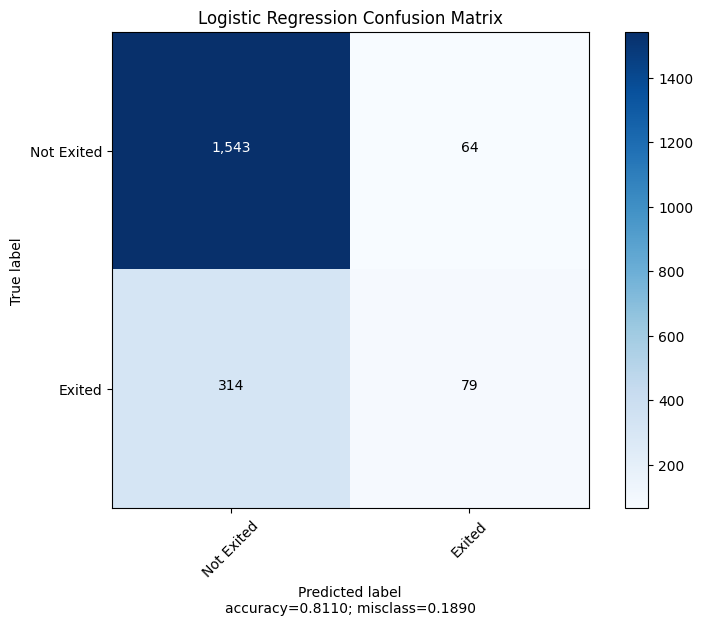

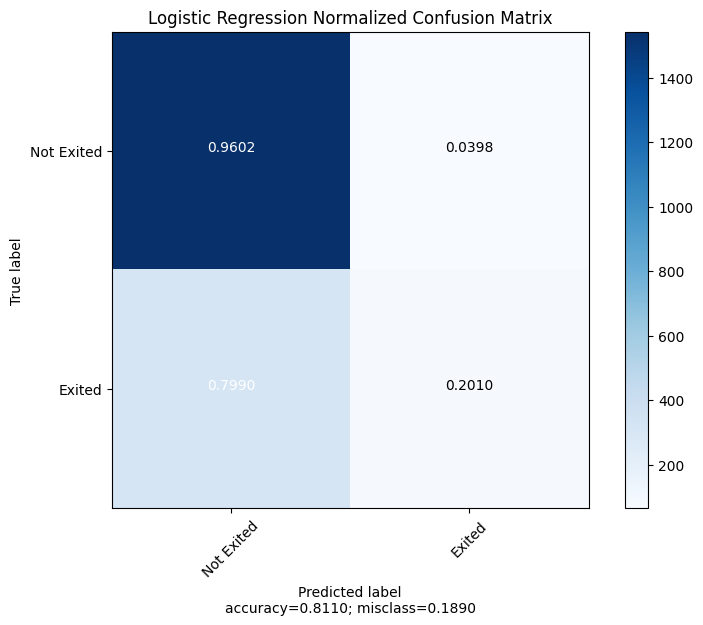

/opt/miniconda3/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


0_precision                             0.885435
1_precision                             0.737643
accuracy_precision                         0.866
macro avg_precision                     0.811539
weighted avg_precision                  0.856394
Model                     Multi-Layer Perceptron
Balanced                                      no
Accuracy                                   0.866
Balanced_Accuracy                       0.725351
AUC                                     0.854854
Name: precision, dtype: object


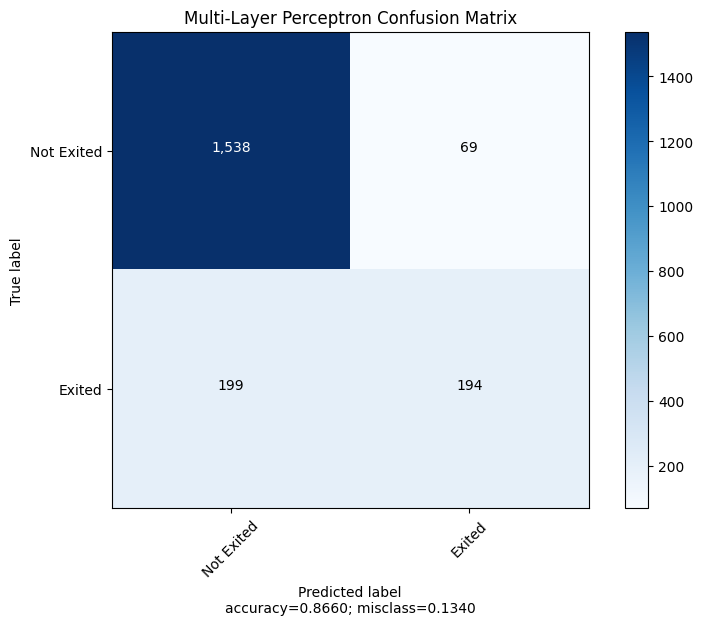

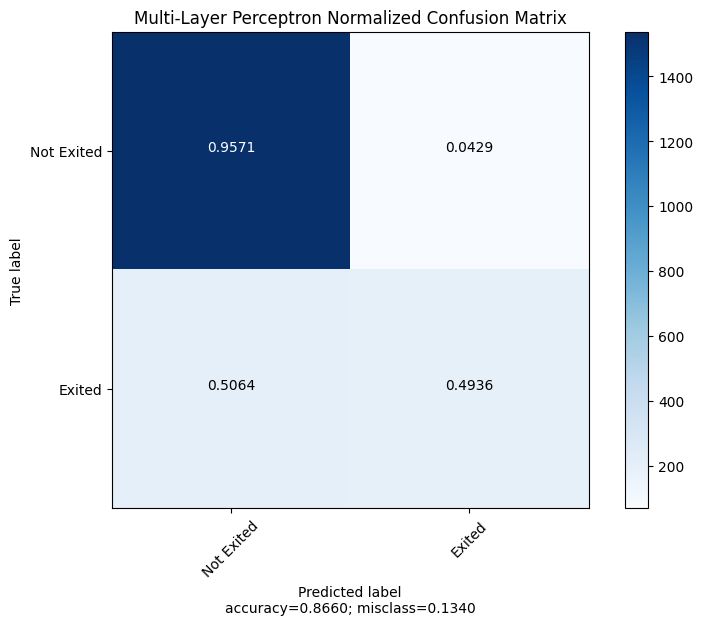

0_precision                        0.884748
1_precision                            0.75
accuracy_precision                   0.8675
macro avg_precision                0.817374
weighted avg_precision              0.85827
Model                     Gradient Boosting
Balanced                                 no
Accuracy                             0.8675
Balanced_Accuracy                  0.724362
AUC                                0.872879
Name: precision, dtype: object


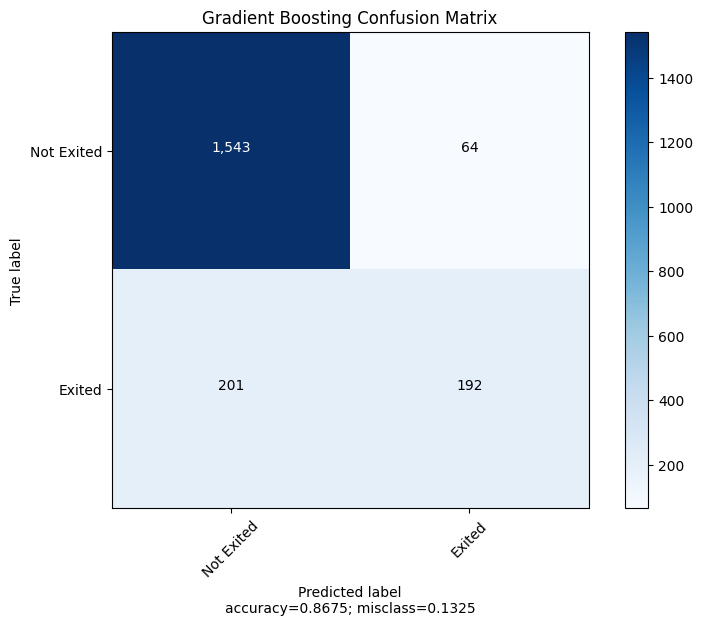

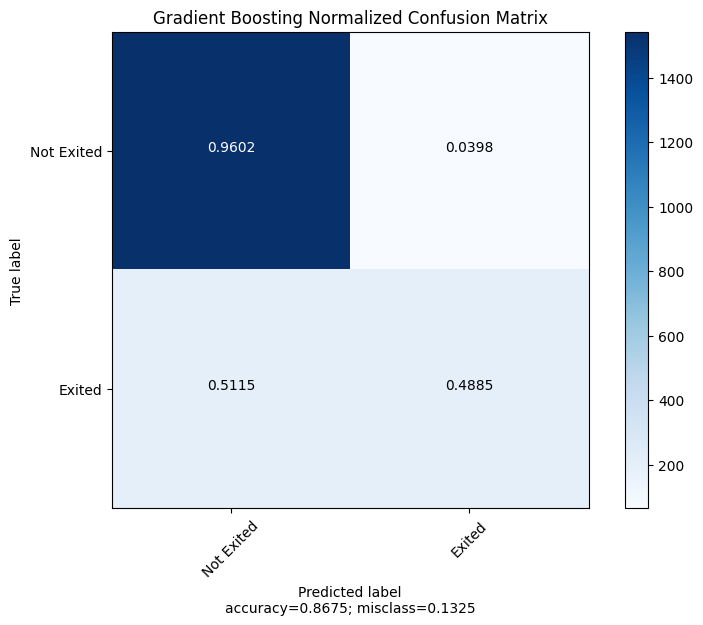

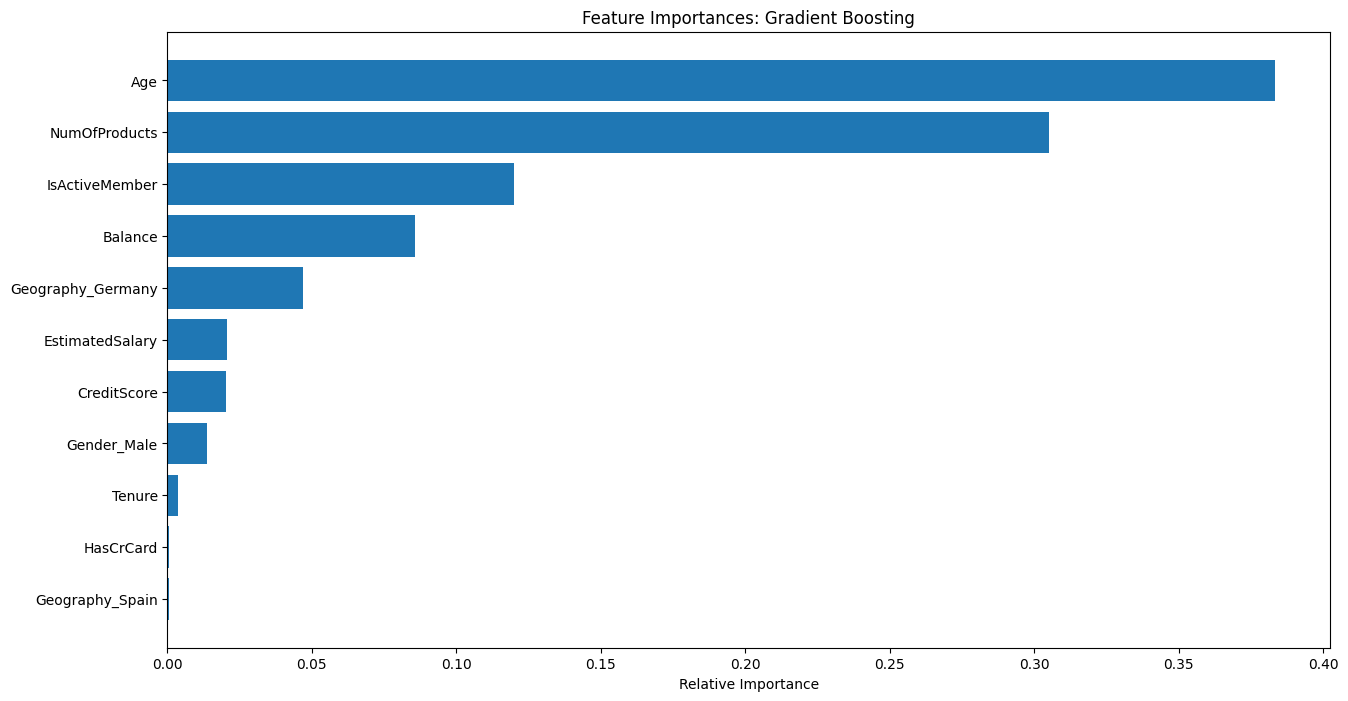

0_precision               0.888759
1_precision               0.713781
accuracy_precision           0.864
macro avg_precision        0.80127
weighted avg_precision    0.854376
Model                      XGBoost
Balanced                        no
Accuracy                     0.864
Balanced_Accuracy         0.731795
AUC                       0.849537
Name: precision, dtype: object


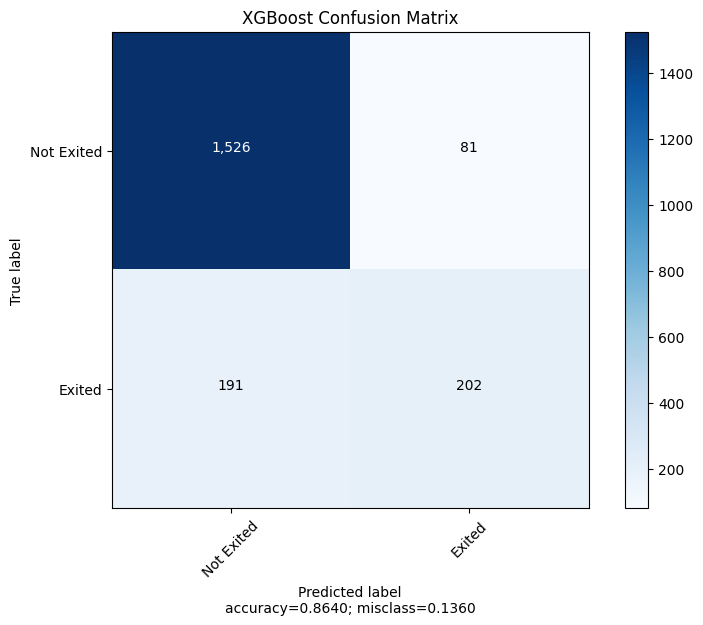

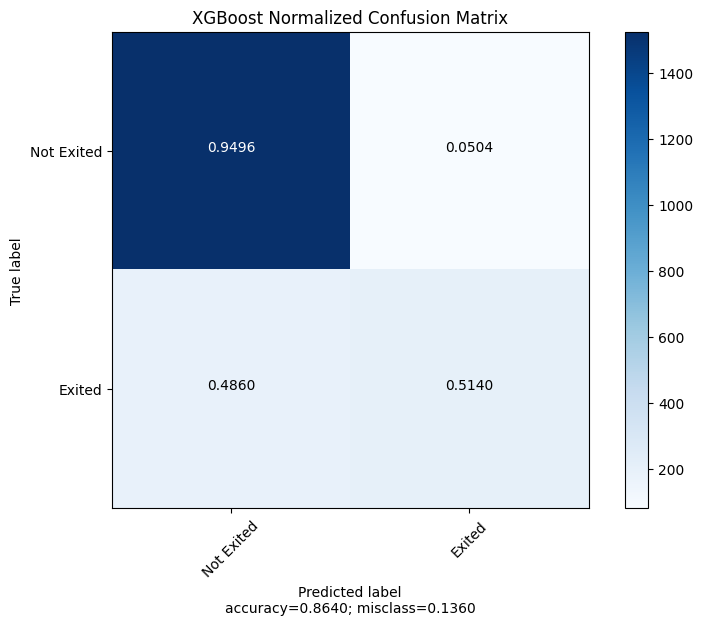

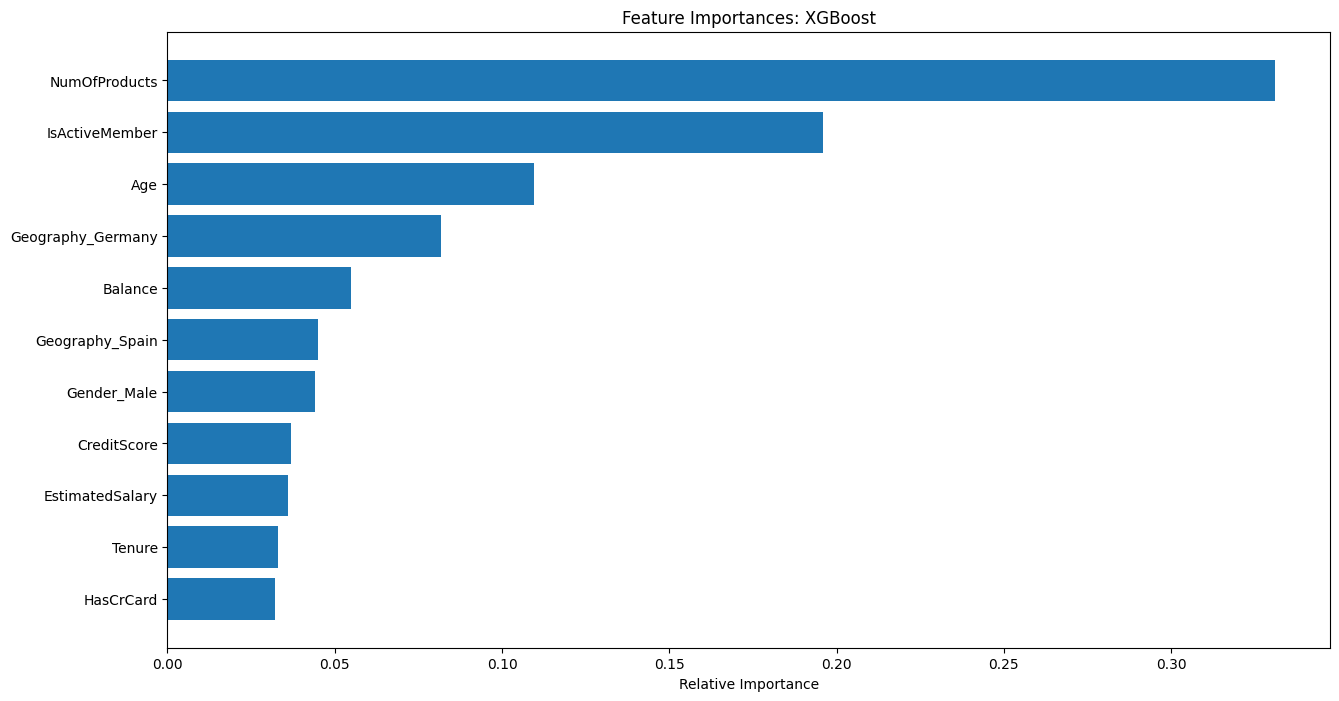

In [14]:
# Train and evaluate models
models = [
    (LogisticRegression(), 'Logistic Regression'),
    (MLPClassifier(), 'Multi-Layer Perceptron'),
    (GradientBoostingClassifier(), 'Gradient Boosting'),
    (XGBClassifier(), 'XGBoost')
]

feature_names = X.columns.tolist()

for model, model_name in models:
    train_and_evaluate_model(model, model_name, X_train, y_train, X_test, y_test, feature_names)

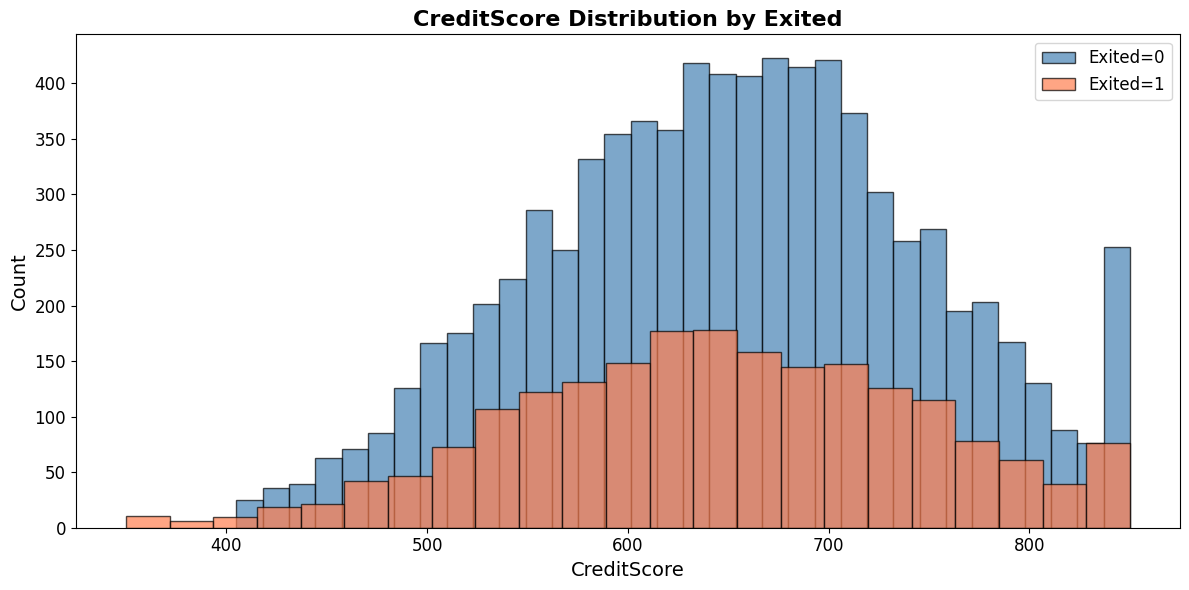

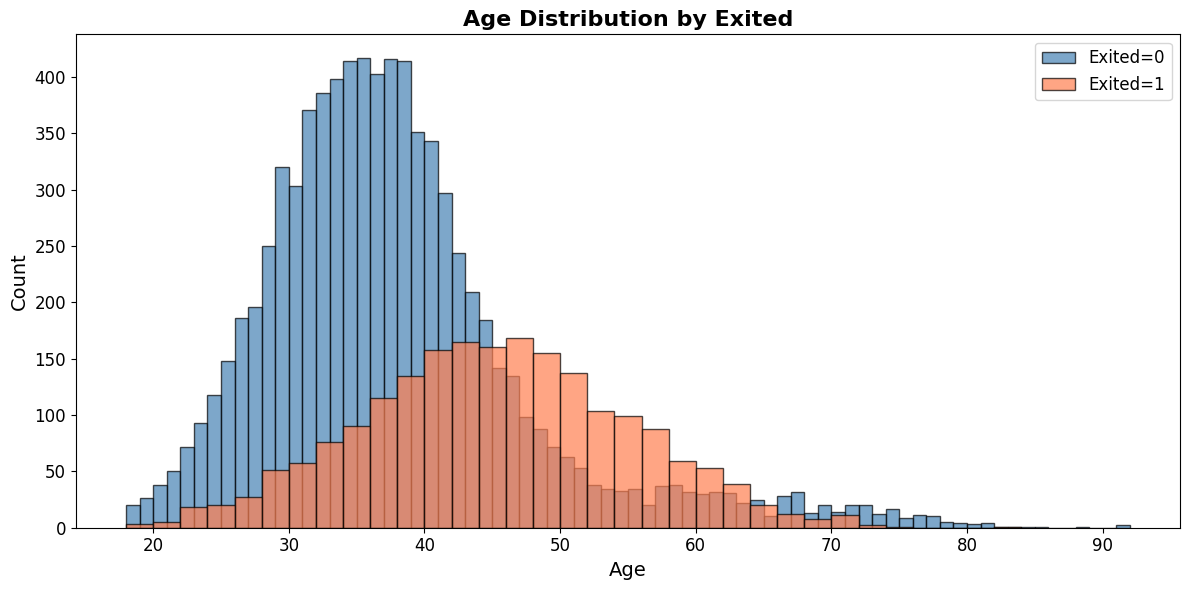

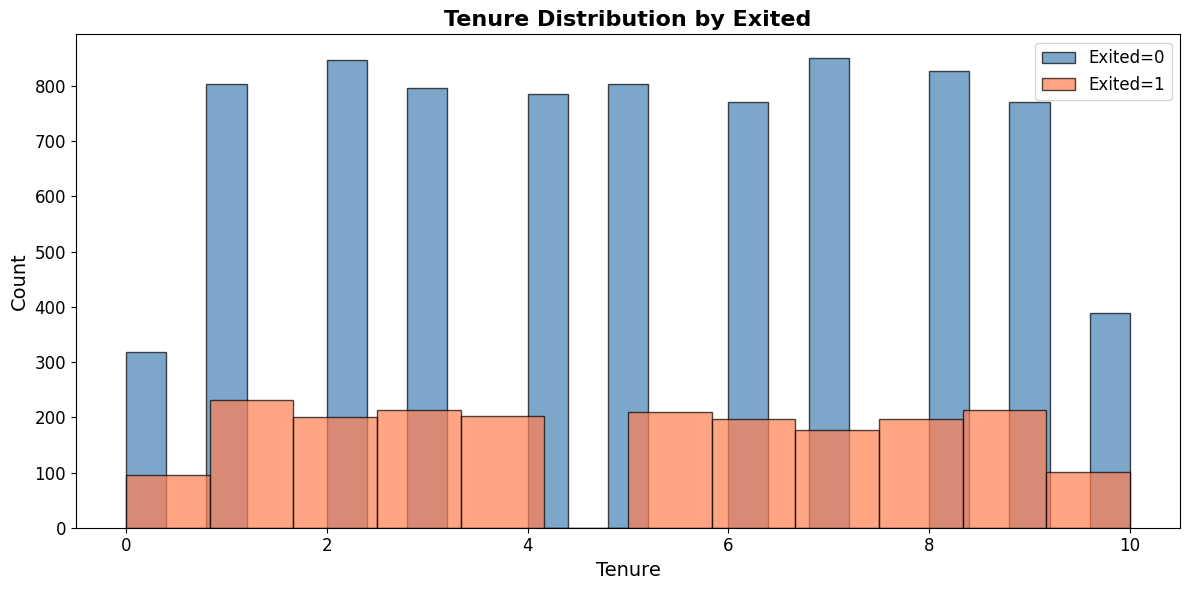

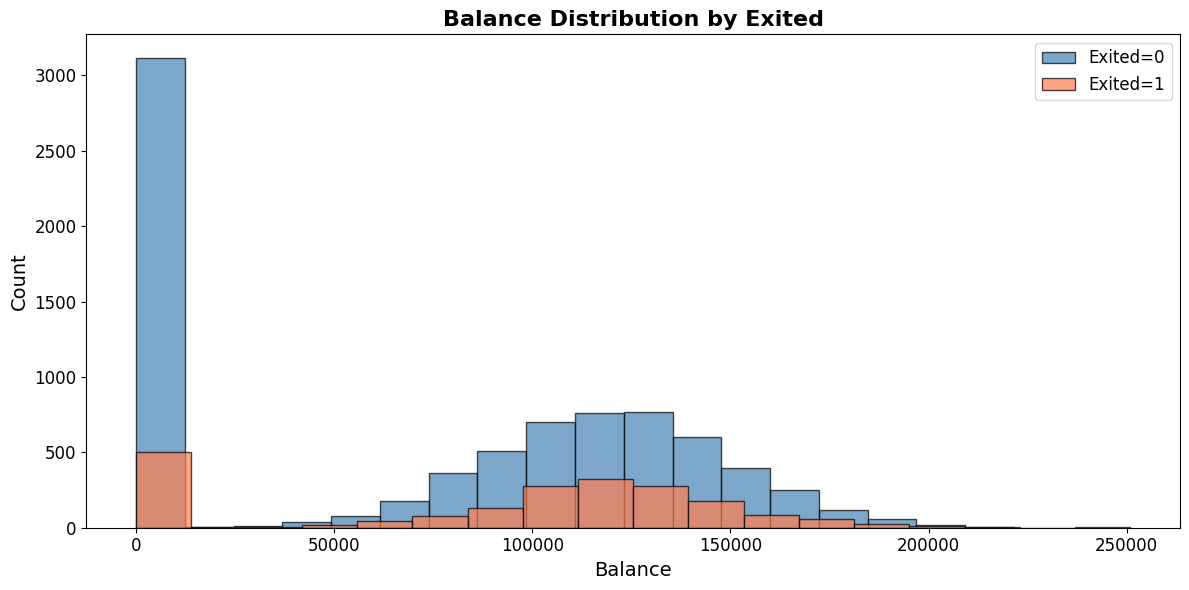

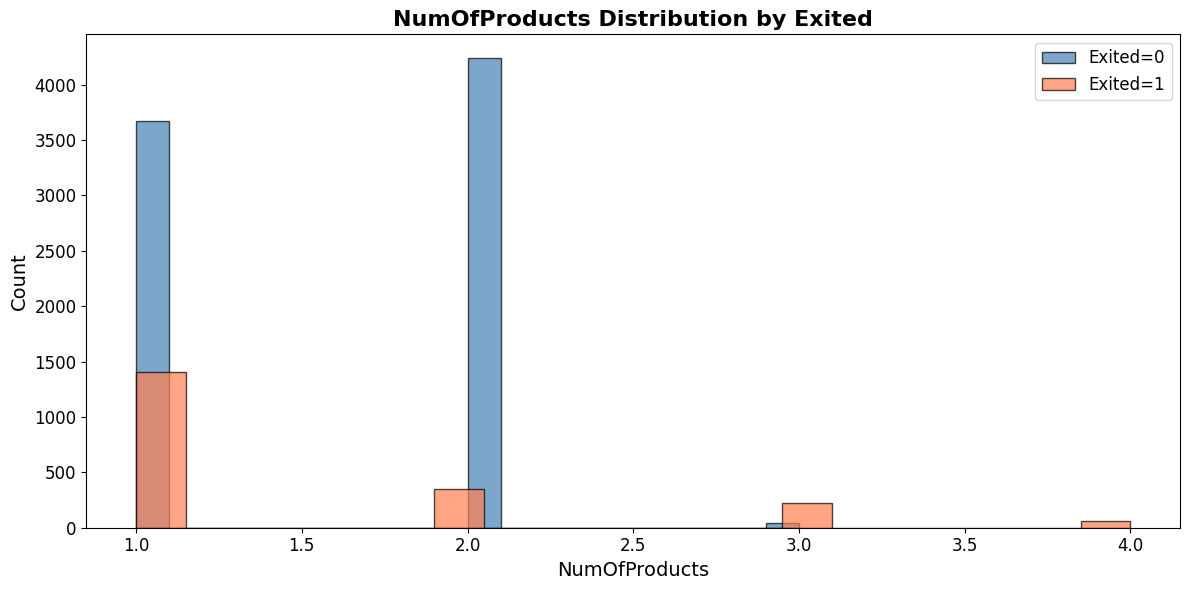

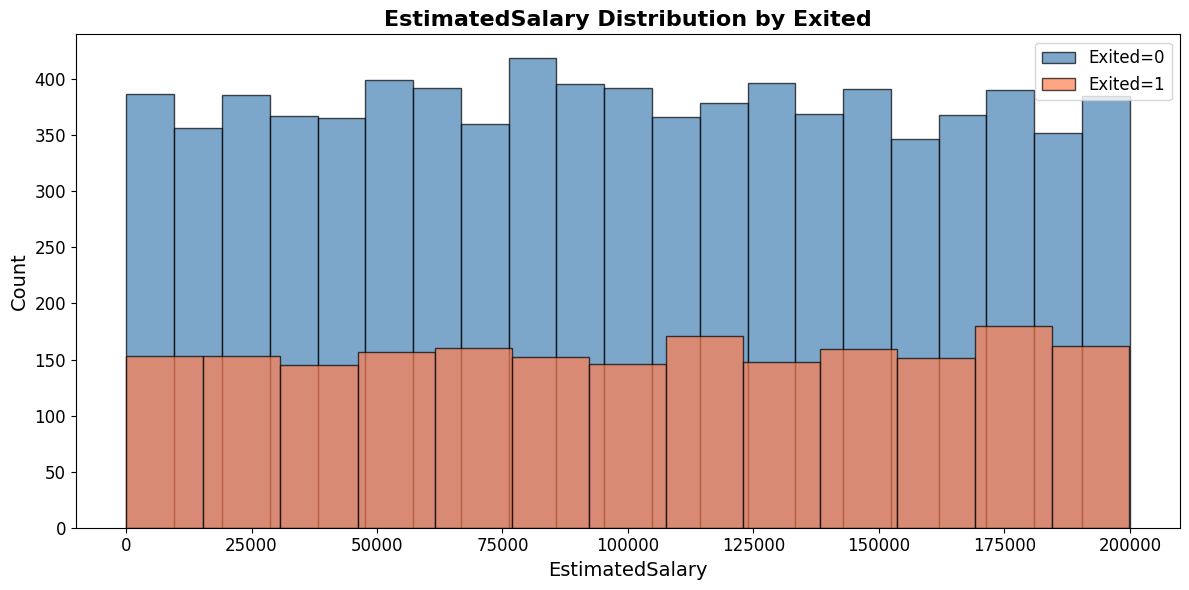

In [19]:
# Plot feature distributions
for feature in numerical_features:
    plot_feature_distributions(dataset, feature, target)